In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/M5/week4")
!ls
!pwd

/content
balloon  balloon_dataset.zip  Detectron2_week4.ipynb  __MACOSX	output
/content/drive/My Drive/Colab Notebooks/M5/week4


# Install detectron2

In [3]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-g13ii7tw
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-g13ii7tw
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275365 sha256=c970443abfec1addee84ff8815fa4f8327c3e1706018dd283bfa23c3ce269520
  Stored in directory: /tmp/pip-ephem-wheel-cache-8f7jvdw0/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software F

In [4]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


# import

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on my dataset

In [0]:
import os
from pycocotools.mask import toBbox, decode
import cv2


def read_gt_txt(gt_txt, gt_path):
    gt_index_str = gt_txt.split(".")[0]
    gt_file = "{}{}".format(gt_path, gt_txt)
    gt = []
    gt_one_frame = []
    time_frame_last = 0
    for line in open(gt_file):
        fields = line.split()
        time_frame = int(fields[0])

        one_instance = [gt_index_str]
        one_instance.extend(fields)

        # print(instance)
        if time_frame == time_frame_last:
            gt_one_frame.append(one_instance)
        else:
            gt.append(gt_one_frame)
            # if time_frame != len(gt):
            #     #raise Exception("time_frame != len(gt)")
            #     print("error")
            gt_one_frame = []
            gt_one_frame.append(one_instance)

        time_frame_last = time_frame

    if len(gt_one_frame) > 0:
        gt.append(gt_one_frame)

    return gt



gt_path = "../../KITTI-MOTS/instances_txt/"
gt_all = []
for gt_id, gt_txt in enumerate(sorted(os.listdir(gt_path))):
    gt = read_gt_txt(gt_txt, gt_path)
    gt_all.extend(gt)


In [0]:
from random import shuffle
shuffle(gt_all)
train_ratio = 0.8
training = gt_all[:int(len(gt_all)*train_ratio)]
validation = gt_all[-int(len(gt_all)*(1.0 - train_ratio) + 1):] 

In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode


def register_from_dataset(dataset_path, dataset):

    dataset_dicts = []
    for idx, v in enumerate(dataset):
        instance_0 = v[0]
        record = {}

        filename = "{}/{}/{}.png".format(dataset_path, instance_0[0], instance_0[1].zfill(6))

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = int(instance_0[4])
        record["width"] = int(instance_0[5])

        objs = []
        for instance in v:
            # do like https://github.com/VisualComputingInstitute/mots_tools/blob/master/mots_common/io.py,
            # mask = {'size': [int(fields[3]), int(fields[4])], 'counts': fields[5].encode(encoding='UTF-8')}
            mask_rle = {'size': [int(instance[4]), int(instance[5])], 'counts': instance[6].encode(encoding='UTF-8')}
            box = toBbox(mask_rle)
            
            #convert rle to poly
            mask = decode(mask_rle)
            # https://github.com/facebookresearch/Detectron/issues/100  Sundrops
            # opencv 3.2
            # mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # before opencv 3.2
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            if len(segmentation) == 0:
                continue
            #End: convert rle to poly
            # print (segmentation)

            ori_class = int(instance[3])
            if ori_class == 1:
                transform_class = 0
            elif ori_class == 2:
                transform_class = 1
            else:
                # transform_class = 2
                continue

            obj = {
                "bbox": [box[0], box[1], box[0] + box[2], box[1] + box[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": segmentation,
                "category_id": transform_class,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_path = "../../KITTI-MOTS/training/image_02"
# thing_classes = ['Car', 'Pedestrian', 'DontCare']
thing_classes = ['Car', 'Pedestrian']

# g = lambda: register_from_dataset(dataset_path, training)
# g()





In [0]:
DatasetCatalog.register("KITTI_MOTS_training", lambda: register_from_dataset(dataset_path, training))
MetadataCatalog.get("KITTI_MOTS_training").set(thing_classes=thing_classes)
DatasetCatalog.register("KITTI_MOTS_val", lambda: register_from_dataset(dataset_path, validation))
MetadataCatalog.get("KITTI_MOTS_val").set(thing_classes=thing_classes)

KITTI_MOTS_metadata = MetadataCatalog.get("KITTI_MOTS_training")

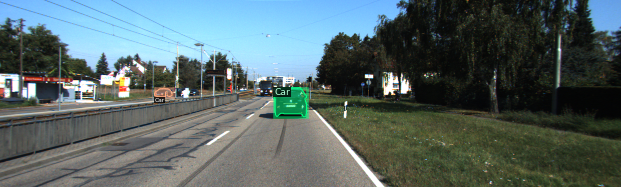

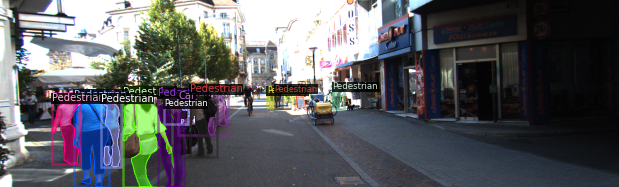

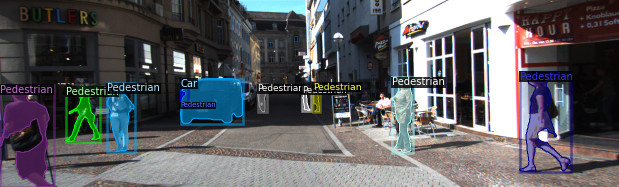

In [10]:
dataset_dicts = register_from_dataset(dataset_path, training)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_MOTS_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("KITTI_MOTS_training",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[03/22 13:37:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (8,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (2,) in the model! Skipped.


In [12]:
trainer.train()

[03/22 13:38:47 d2.engine.train_loop]: Starting training from iteration 0
[03/22 13:38:54 d2.utils.events]:  eta: 0:18:50  iter: 19  total_loss: 2.700  loss_cls: 1.051  loss_box_reg: 0.839  loss_mask: 0.694  loss_rpn_cls: 0.067  loss_rpn_loc: 0.025  time: 0.3022  data_time: 0.0898  lr: 0.000005  max_mem: 1696M
[03/22 13:38:58 d2.utils.events]:  eta: 0:18:36  iter: 39  total_loss: 2.617  loss_cls: 0.996  loss_box_reg: 0.850  loss_mask: 0.685  loss_rpn_cls: 0.057  loss_rpn_loc: 0.018  time: 0.2616  data_time: 0.0054  lr: 0.000010  max_mem: 1696M
[03/22 13:39:04 d2.utils.events]:  eta: 0:18:32  iter: 59  total_loss: 2.479  loss_cls: 0.898  loss_box_reg: 0.883  loss_mask: 0.671  loss_rpn_cls: 0.048  loss_rpn_loc: 0.023  time: 0.2763  data_time: 0.0877  lr: 0.000015  max_mem: 1696M
[03/22 13:39:09 d2.utils.events]:  eta: 0:18:28  iter: 79  total_loss: 2.337  loss_cls: 0.769  loss_box_reg: 0.846  loss_mask: 0.642  loss_rpn_cls: 0.055  loss_rpn_loc: 0.019  time: 0.2642  data_time: 0.0113  lr:

In [0]:
!kill 3422

In [18]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("KITTI_MOTS_val", )
predictor = DefaultPredictor(cfg)

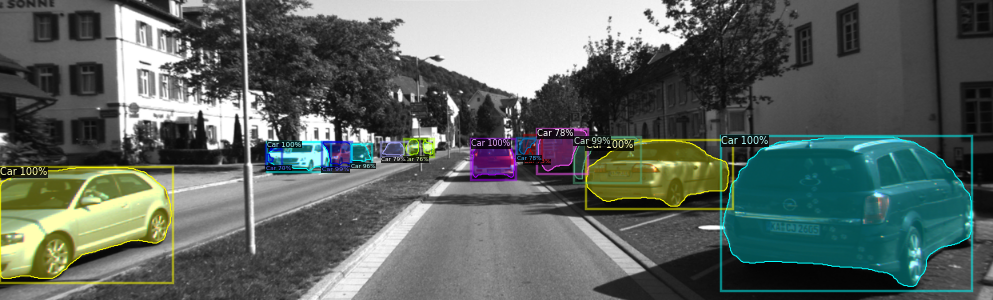

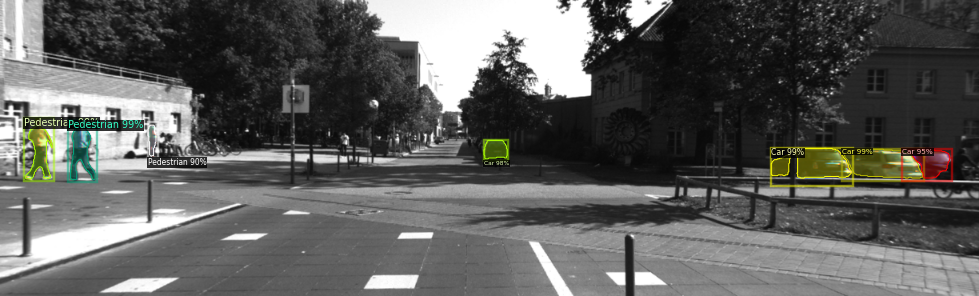

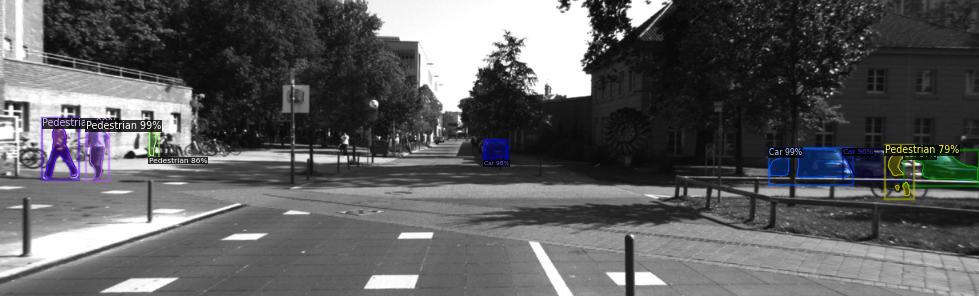

In [15]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = register_from_dataset(dataset_path, validation)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=KITTI_MOTS_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("KITTI_MOTS_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "KITTI_MOTS_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [03/22 13:59:26 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'KITTI_MOTS_val'. Trying to convert it to COCO format ...
[03/22 13:59:26 d2.data.datasets.coco]: Converting dataset annotations in 'KITTI_MOTS_val' to COCO format ...)
[03/22 13:59:38 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/22 13:59:40 d2.data.datasets.coco]: Conversion finished, num images: 1586, num annotations: 7610
[03/22 13:59:40 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/KITTI_MOTS_val_coco_format.json
[03/22 13:59:53 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Car     | 5227         | Pedestrian | 2383         |
|            |              |            |              |
|   total    | 7610         |            |              |
[03/22 13:59:53 d2.data.common]: Serializing 1586 elemen

OrderedDict([('bbox',
              {'AP': 68.36021561019295,
               'AP-Car': 76.00103842415551,
               'AP-Pedestrian': 60.719392796230395,
               'AP50': 90.78449004432261,
               'AP75': 79.02453698903362,
               'APl': 83.58468234199468,
               'APm': 77.65917617084726,
               'APs': 53.61419481343792}),
             ('segm',
              {'AP': 59.93408093433554,
               'AP-Car': 74.08619291318153,
               'AP-Pedestrian': 45.78196895548956,
               'AP50': 86.91556302201874,
               'AP75': 66.2981822452787,
               'APl': 85.36192974662083,
               'APm': 69.37454782016108,
               'APs': 41.18771664171842})])